# Regulome Explorer  ChiSquare test for categorical features
Check out more notebooks at our ['Regulome Explorer Repository'](https://github.com/isb-cgc/Community-Notebooks/tree/master/RegulomeExplorer)!

In this notebook we describe how Regulome Explorer uses the Chi-square test to compute statistical associations between two categorical features. This test is used when one of the categorical features has more than two categories. Fisher's exact test is used for the special case in which both features has only two categories. The Fisher's exact test is described in another notebook.

We will use clinical data and Somatic mutations for this test, both of these features are available in BigQuery Tables. Details of the Chi-sqaure ttest can be found in the following link: https://en.wikipedia.org/wiki/Chi-squared_test



## Authenticate with Google  (IMPORTANT)
Our first step is to authenticate with Google -- you will need to be a member of a Google Cloud Platform (GCP) project, with authorization to run BigQuery jobs in order to run this notebook.  If you don't have access to a GCP project, please contact the ISB-CGC team for help (www.isb-cgc.org)

#### Import Python libraries

In [2]:
from google.cloud import bigquery
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import re_module.bq_functions as regulome

## Userdefined Parameters
The parameters for this experiment are the cancer type, the name of the clinical feature, the name of the gene for which mutation can be extracted, and the minimun number of participant for categories to be considered. The clinical feature must be categorical. 

In [3]:
cancer_type = 'BRCA'
clinical_name = 'histological_type'
mutation_name = 'CDH1'
MinSampleSize = 10

bqclient = bigquery.Client()

## Data from BigQeury tables

Clinical data from the BigQuery. The following string query will retrieve clinical data fromthe 'pancancer-atlas.Filtered.clinical_PANCAN_patient_with_followup_filtered' table available in pancancer-atlas dataset. 

In [3]:
query_table1 = """table1 AS (
SELECT
   symbol,
   avgdata AS data,
   ParticipantBarcode
FROM (
   SELECT
      '{0}' AS symbol, 
      {0} AS avgdata,
      bcr_patient_barcode AS ParticipantBarcode
   FROM `pancancer-atlas.Filtered.clinical_PANCAN_patient_with_followup_filtered`
   WHERE acronym = '{1}'   AND {0} IS NOT NULL      
   )
)
""".format(clinical_name, cancer_type)

Somatic mutation data from Bigquery table. The following string query will retrieve a table with patients with at least one Somatic mutation in the user defined gene ('mutation_name'). This information is extracted from the 'pancancer-atlas.Filtered.MC3_MAF_V5_one_per_tumor_sample' table, available in pancancer-atlas dataset. Notice that we only use samples in which FILTER = 'PASS'. 

In [4]:
query_table2 = """table2 AS (
SELECT
   symbol,
   ParticipantBarcode
FROM (
   SELECT
      Hugo_Symbol AS symbol, 
      ParticipantBarcode AS ParticipantBarcode
   FROM `pancancer-atlas.Filtered.MC3_MAF_V5_one_per_tumor_sample`
   WHERE Study = '{1}' AND Hugo_Symbol = '{0}'
         AND FILTER = 'PASS'  
   GROUP BY
      ParticipantBarcode, symbol
   )
)
""".format( mutation_name , cancer_type )

The following query combines the two tables based on Participant barcodes. Data of participants for which one feature is missing are not being used. Nij is the number of participants for each pair of categories. data1 is the categorical data fo the clinical feature specified by the user, and data is binary data which is 'YES' for pariticpants with mutation in the gene especified by the user.  

In [5]:
query_summarize = """summ_table AS (
SELECT 
   n1.data as data1,
   IF( n2.ParticipantBarcode is null, 'NO', 'YES') as data2,
   COUNT(*) as Nij
FROM
   table1 AS n1
LEFT JOIN
   table2 AS n2
ON
   n1.ParticipantBarcode = n2.ParticipantBarcode
GROUP BY
  data1, data2
) 
""".format(str(MinSampleSize) )

At this point we can take a look at output table, where the column **Nij** is the number of participants for each pair of categorical values.

In [7]:
sql = ( 'WITH\n' + query_table1 + ',' + query_table2 + ',' + query_summarize +
"""SELECT * FROM summ_table 
   ORDER BY  data1
""")

df_results = regulome.runQuery ( bqclient, sql, [] , dryRun=False )
df_results


 in runQuery ... 
    the results for this query were previously cached 


,data1,data2,Nij
0,Infiltrating Carcinoma NOS,NO,1
1,Infiltrating Ductal Carcinoma,NO,768
2,Infiltrating Ductal Carcinoma,YES,9
3,Infiltrating Lobular Carcinoma,YES,83
4,Infiltrating Lobular Carcinoma,NO,118
5,Medullary Carcinoma,NO,5
6,Medullary Carcinoma,YES,1
7,Metaplastic Carcinoma,NO,8
8,Mixed Histology (please specify),NO,26
9,Mixed Histology (please specify),YES,4


The table shows that **data2** (Gene mutations) has two categories and **data1** (Clinical feature ) in this case has 8 categories. We can use python to visualize the populations in each category. 

/Users/borisaguilar/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


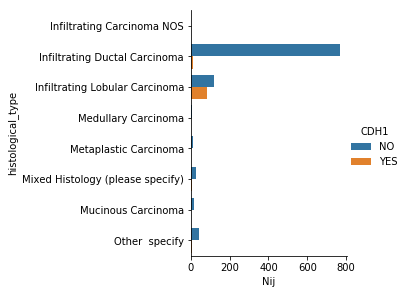

In [8]:
df_results.rename(columns={ "data1": clinical_name, "data2": mutation_name }, inplace=True)
sns.catplot(y=clinical_name, x="Nij",hue=mutation_name,data=df_results, kind="bar",height=4, aspect=.7)

##  Compute the statistics 
After sumarizing the data in the table above, we are in the position to perform the Chi-Square test. Before the description of the test we need the following definitions:

- **Nij**     : Number of participants for each pair of categories
- **N**       : Total number of participants ( N = sum_ij Nij )
- **Ni**      : The total number of participants with category of data1(Clinical data) equal to i
- **Nj**      : The total number of participants with category of data2(Somatic mutation) equal to j
- **E_nij** : Expected number of participants for each pair of categories under the null hypothesis. E_nij = (Ni\*Nj)/N
- **I, J** : The number of categories in data1 and data2 respectively

The implementation of the Chi-Square test consists of two steps:

1 ) Generate the contingency table (see https://en.wikipedia.org/wiki/Contingency_table ) which in our case is a table with the values of **Nij** and **E_nij** for each pair of categorical values.

2 ) Compute Chi-square value as :
    $$\chi^2 = \sum_{i=1}^{I}\sum_{j=1}^{J}\frac{ (N_{ij} - E[n_{ij}] )^2 }{E[n_{ij}]}$$

To generate the contingency table we first use CROSS JOIN to form a table with all possible pairs between the two categorical features. Only categories with more than 'MinSampleSize' are considered, 5 is typically used for the Chi-Squared test. The following string performs that operation:

In [9]:
query_expected= """expected_table AS (
SELECT data1, data2
FROM (     
    SELECT data1, SUM(Nij) as Ni   
    FROM summ_table
    GROUP BY data1 ) 
CROSS JOIN ( 
    SELECT data2, SUM(Nij) as Nj
    FROM summ_table
    GROUP BY data2 )
    
WHERE Ni > {0} AND Nj > {0}
)
""".format(str(MinSampleSize) )

sql = ( 'WITH\n' + query_table1 + ',' + query_table2 + ',' + query_summarize + ',' + query_expected +
"""SELECT * FROM expected_table 
""")  

regulome.runQuery ( bqclient, sql, [] , dryRun=False )


 in runQuery ... 
    the results for this query were previously cached 


,data1,data2
0,Infiltrating Lobular Carcinoma,YES
1,Infiltrating Lobular Carcinoma,NO
2,Other specify,YES
3,Other specify,NO
4,Infiltrating Ductal Carcinoma,YES
5,Infiltrating Ductal Carcinoma,NO
6,Mixed Histology (please specify),YES
7,Mixed Histology (please specify),NO
8,Mucinous Carcinoma,YES
9,Mucinous Carcinoma,NO


Notice the resulting table has $I * J$  rows. Next, the contingency table is generated by using an "INNER JOIN" and filling the missing values of **Nij** with zeros (the IF statement in the query below).

In [11]:
query_contingency = """contingency_table AS (
SELECT
   T1.data1,
   T1.data2,
   IF( Nij IS NULL, 0, Nij) as Nij,
   (SUM(Nij) OVER (PARTITION BY T1.data1))*(SUM(Nij) OVER (PARTITION BY T1.data2))/ SUM(Nij) OVER () AS  E_nij
    
FROM
   expected_table AS T1
LEFT JOIN
   summ_table AS T2
ON 
  T1.data1 = T2.data1 AND T1.data2 = T2.data2
)
"""

sql = ( 'WITH\n' + query_table1 + ',' + query_table2 + ',' + query_summarize + ',' + query_expected + ',' + query_contingency +
"""SELECT * FROM contingency_table
   ORDER BY data2, data1
""")       

df_contingency = regulome.runQuery ( bqclient, sql, [] , dryRun=False )
df_contingency


 in runQuery ... 
    the results for this query were previously cached 


,data1,data2,Nij,E_nij
0,Infiltrating Ductal Carcinoma,NO,768,705.176471
1,Infiltrating Lobular Carcinoma,NO,118,182.420168
2,Mixed Histology (please specify),NO,26,27.226891
3,Mucinous Carcinoma,NO,17,15.428571
4,Other specify,NO,43,41.747899
5,Infiltrating Ductal Carcinoma,YES,9,71.823529
6,Infiltrating Lobular Carcinoma,YES,83,18.579832
7,Mixed Histology (please specify),YES,4,2.773109
8,Mucinous Carcinoma,YES,0,1.571429
9,Other specify,YES,3,4.252101


From this contingency table, we can use python to compute the Chi-Square statistics from the contingency table. This is used to validate our BigQuery implementation:

In [12]:
yes_a = df_contingency[  df_contingency['data2']  == 'NO' ]['Nij'].values
no_a  = df_contingency[  df_contingency['data2']  == 'YES' ]['Nij'].values 
conting_table = [yes_a  , no_a]

chi2, p, dof, expected_nij = stats.chi2_contingency( conting_table ) 
print( "Chi2, p, dof : ", chi2, p , dof)
print( "Expected nij : ")
print(expected_nij)

Chi2, p, dof :  309.39167298726557 1.020302231598449e-65 4
Expected nij : 
[[705.17647059 182.42016807  27.22689076  15.42857143  41.74789916]
 [ 71.82352941  18.57983193   2.77310924   1.57142857   4.25210084]]


The following query string computes the Chi-square and the Cramer's V statistics from the contingency table.

In [13]:
sql = ( 'WITH\n' + query_table1 + ',' + query_table2 + ',' + query_summarize + ',' + query_expected + ',' + query_contingency +
"""
SELECT I, J, N, Chi2,
       IF(I > J, SQRT( Chi2 /(N*(J-1))),SQRT(Chi2/(N*(I-1)) ) ) as V
FROM (
   SELECT
     COUNT( DISTINCT data1 ) as I,
     COUNT( DISTINCT data2 ) as J,
     SUM(Nij) as N,
     SUM( (Nij - E_nij)*(Nij - E_nij) / E_nij ) as Chi2    
   FROM contingency_table
     )
""")       

df_chi = regulome.runQuery ( bqclient, sql, [] , dryRun=False )
df_chi


 in runQuery ... 
    the results for this query were previously cached 


,I,J,N,Chi2,V
0,5,2,1071,309.391673,0.537477


The computed Chi2 using BigQuery can be compared to that obtained with python. A large value of Chi2 indicates that the null hypothesis (that data1 and data2 has no association) is rather unlikely. The degrees of freedom ($IJ-I-J-1$) and the Chi2 value are need to compute the p value of the null hypothesis. 